In [1]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from data_loader_dan import get_loader
from models_dan_adhiraj import VqaModel, SANModel

from utils import text_helper
from matplotlib import pyplot as plt
import cv2
from PIL import Image

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
input_dir = './datasets'
max_qst_length = 30
max_num_ans = 10
batch_size = 1 #192
num_workers = 1

data_loader = get_loader(
        input_dir=input_dir,
        input_vqa_train='train.npy',
        input_vqa_valid='valid.npy',
        max_qst_length=max_qst_length,
        max_num_ans=max_num_ans,
        batch_size=batch_size,
        num_workers=num_workers)

qst_vocab = text_helper.VocabDict(input_dir+'/vocab_questions.txt')
ans_vocab = text_helper.VocabDict(input_dir+'/vocab_answers.txt')

vqa = np.load('datasets/train.npy', allow_pickle=True)
vqa_neighbors= np.load('train_neighbor_matrix_small.npy', allow_pickle=True)
print(vqa_neighbors.shape, vqa.shape)

(443757, 300) (443757,)


In [ ]:
qst_vocab_size = data_loader['train'].dataset.qst_vocab.vocab_size
ans_vocab_size = data_loader['train'].dataset.ans_vocab.vocab_size
ans_unk_idx = data_loader['train'].dataset.ans_vocab.unk2idx
print(qst_vocab_size, ans_vocab_size, ans_unk_idx)

embed_size = 1024
word_embed_size = 300
num_layers = 2
hidden_size = 512

model = SANModel(
    embed_size=embed_size,
    qst_vocab_size=qst_vocab_size,
    ans_vocab_size=ans_vocab_size,
    word_embed_size=word_embed_size,
    num_layers=num_layers,
    hidden_size=hidden_size)

model = nn.DataParallel(model)
model = model.to(device)


model.load_state_dict(torch.load('adhiraj_models/dan_pi_farther_neighbours_1-best_model.ckpt')['state_dict'])
model.eval()


17856 1000 0


In [ ]:
# for batch_idx, batch_sample in enumerate(data_loader['valid']):
for batch_idx, batch_sample in enumerate(data_loader['train']):
    image_index = batch_sample['index']
    
    image = batch_sample['image'].to(device)
    question = batch_sample['question'].to(device)
    label = batch_sample['answer_label'].to(device)
    multi_choice = batch_sample['answer_multi_choice']  # not tensor, list.

    output, target_img_attn_scores = model(image, question)      # [batch_size, ans_vocab_size=1000]
    # target_img_attn_scores = model.attn_features
    
    # Exp2: our model prediction to '<unk>' is NOT accepted as the answer.
    _, pred_exp2 = torch.max(output, 1)  # [batch_size]
    pred_exp2[pred_exp2 == ans_unk_idx] = -9999
    running_corr_exp2 = torch.stack([(ans == pred_exp2.cpu()) for ans in multi_choice]).any(dim=0).sum()
    pred_exp2_idc2ans = ['unkown' if(w==-9999) else ans_vocab.idx2word(w) for w in pred_exp2.cpu()]
    
    supporting_example_image = batch_sample['supporting_example_image'].to(device)
    _, supporting_example_attn_scores = model(supporting_example_image, question)      # [batch_size, ans_vocab_size=1000, attn_scores=196]
    # supporting_example_attn_scores = model.attn_features
    
    opposing_example_image = batch_sample['opposing_example_image'].to(device)
    _, opposing_example_attn_scores = model(opposing_example_image, question)      # [batch_size, ans_vocab_size=1000, attn_scores=196]
    # opposing_example_attn_scores = model.attn_features
    
    
    break

In [36]:
import random
batch_idx = random.sample(range(192),1)[0]

idx = batch_sample['index'][batch_idx].detach().numpy()
ans_for_batch_idx = pred_exp2_idc2ans[batch_idx]

print("Vqa data index:",idx)
t_image = vqa[idx]['image_path']
t_image = Image.open(t_image).convert('RGB')
print(vqa[idx]['question_str'])
print(vqa[idx]['valid_answers'])

near_idx = np.random.randint(1,49,1)[0]
s_image = vqa[vqa_neighbors[idx, near_idx]]['image_path']
s_image = Image.open(s_image).convert('RGB')

#far_idx = np.random.randint(1000,1200,1)[0]
far_idx = np.random.randint(101,249,1)[0]
o_image = vqa[vqa_neighbors[idx, far_idx]]['image_path']
o_image = Image.open(o_image).convert('RGB')

Vqa data index: 403335
What is the guy on?
['road', 'skateboard', 'skateboard', 'skateboard', 'skateboard', 'skateboard', 'skateboard', 'skateboard', 'skateboard']


In [ ]:
# ### for custom index
# import torchvision.transforms as transforms
# idx = 403335
# max_qst_length = 30
# max_num_ans = 10
# transform = transforms.Compose([transforms.ToTensor(),
#                                transforms.Normalize((0.485, 0.456, 0.406),
#                                                     (0.229, 0.224, 0.225))])
# image = vqa[idx]['image_path']
# image = Image.open(image).convert('RGB')

# near_idx = np.random.randint(1,74,1)[0]
# s_image = vqa[vqa_neighbors[idx, near_idx]]['image_path']
# s_image = Image.open(s_image).convert('RGB')

# #far_idx = np.random.randint(1000,1200,1)[0]
# far_idx = np.random.randint(76,275,1)[0]
# o_image = vqa[vqa_neighbors[idx, far_idx]]['image_path']
# o_image = Image.open(o_image).convert('RGB')

# qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)  # padded with '<pad>' in 'ans_vocab'
# qst2idc[:len(vqa[idx]['question_tokens'])] = [qst_vocab.word2idx(w) for w in vqa[idx]['question_tokens']]

# sample = {'index': idx, 'image': image, 'supporting_example_image': s_image, 'opposing_example_image': o_image, 'question': qst2idc}

# ans2idc = [ans_vocab.word2idx(w) for w in vqa[idx]['valid_answers']]
# ans2idx = np.random.choice(ans2idc)
# sample['answer_label'] = ans2idx         # for training
# mul2idc = list([-1] * max_num_ans)       # padded with -1 (no meaning) not used in 'ans_vocab'
# mul2idc[:len(ans2idc)] = ans2idc         # our model should not predict -1
# sample['answer_multi_choice'] = mul2idc  # for evaluation metric of 'multiple choice'

# sample['image'] = transform(sample['image'])
# sample['supporting_example_image'] = transform(sample['supporting_example_image'])
# sample['opposing_example_image'] = transform(sample['opposing_example_image'])

# batch_sample['image'][0] = sample['image']
# batch_sample['supporting_example_image'][0] = sample['supporting_example_image']
# batch_sample['opposing_example_image'][0] = sample['opposing_example_image']
# batch_sample['question'][0] = sample['question']
# batch_sample['answer_label'][0] = sample['answer_label']
# batch_sample['answer_multi_choice'][0] = sample['answer_multi_choice']

# ##### inference
# image = batch_sample['image'].to(device)
# question = batch_sample['question'].to(device)
# label = batch_sample['answer_label'].to(device)
# multi_choice = batch_sample['answer_multi_choice']  # not tensor, list.

# output, target_img_attn_scores = model(image, question)      # [batch_size, ans_vocab_size=1000]
# # target_img_attn_scores = model.attn_features

# # Exp2: our model prediction to '<unk>' is NOT accepted as the answer.
# _, pred_exp2 = torch.max(output, 1)  # [batch_size]
# pred_exp2[pred_exp2 == ans_unk_idx] = -9999
# running_corr_exp2 = torch.stack([(ans == pred_exp2.cpu()) for ans in multi_choice]).any(dim=0).sum()
# pred_exp2_idc2ans = ['unkown' if(w==-9999) else ans_vocab.idx2word(w) for w in pred_exp2.cpu()]

# supporting_example_image = batch_sample['supporting_example_image'].to(device)
# _, supporting_example_attn_scores = model(supporting_example_image, question)      # [batch_size, ans_vocab_size=1000, attn_scores=196]
# # supporting_example_attn_scores = model.attn_features

# opposing_example_image = batch_sample['opposing_example_image'].to(device)
# _, opposing_example_attn_scores = model(opposing_example_image, question)      # [batch_size, ans_vocab_size=1000, attn_scores=196]

332559 - gender


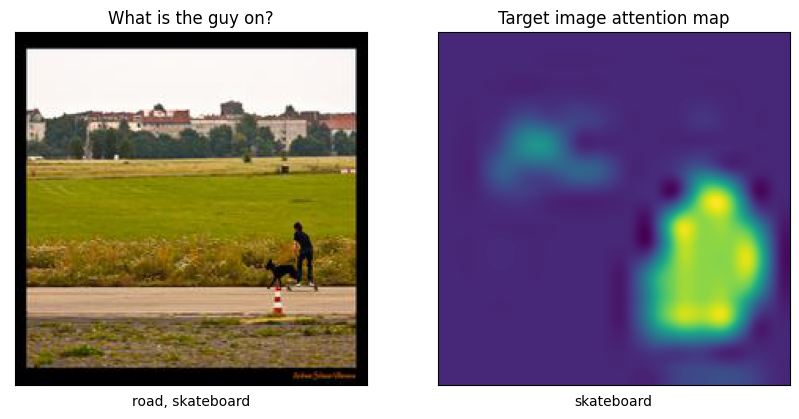

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

t_image = np.array(t_image)
ax[0].imshow(t_image)
ax[0].title.set_text(vqa[idx]['question_str'])
ax[0].set_xlabel(', '.join(np.unique(vqa[idx]['valid_answers'])))

attn_map_1 = target_img_attn_scores[batch_idx, :].reshape(14, 14)
attn_map_1 = cv2.resize(attn_map_1.detach().cpu().numpy(),(224,224), interpolation=cv2.INTER_CUBIC)
ax[1].title.set_text('Target image attention map')
ax[1].imshow(attn_map_1)
ax[1].set_xlabel(ans_for_batch_idx)

# remove the x and y ticks
for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])

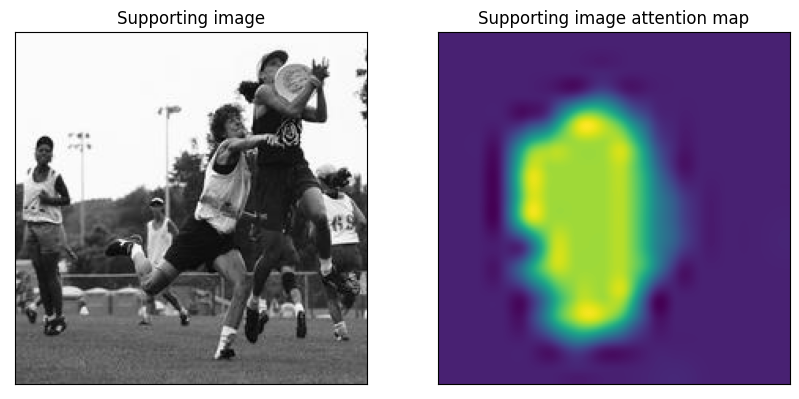

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

s_image = np.array(s_image)
ax[0].imshow(s_image)
ax[0].title.set_text('Supporting image')
# ax[0].set_xlabel(', '.join(np.unique(vqa[idx]['valid_answers'])))

attn_map_1 = supporting_example_attn_scores[batch_idx, :].reshape(14, 14)
attn_map_1 = cv2.resize(attn_map_1.detach().cpu().numpy(),(224,224), interpolation=cv2.INTER_CUBIC)
ax[1].title.set_text('Supporting image attention map')
ax[1].imshow(attn_map_1)

# remove the x and y ticks
for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])

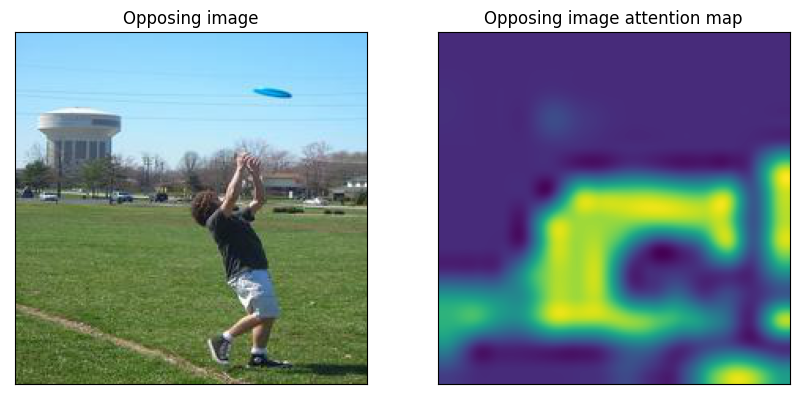

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

o_image = np.array(o_image)
ax[0].imshow(o_image)
ax[0].title.set_text('Opposing image')
# ax[0].set_xlabel(', '.join(np.unique(vqa[idx]['valid_answers'])))

attn_map_1 = opposing_example_attn_scores[batch_idx, :].reshape(14, 14)
attn_map_1 = cv2.resize(attn_map_1.detach().cpu().numpy(),(224,224), interpolation=cv2.INTER_CUBIC)
ax[1].title.set_text('Opposing image attention map')
ax[1].imshow(attn_map_1)

# remove the x and y ticks
for axi in ax:
    axi.set_xticks([])
    axi.set_yticks([])